In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plotting utilities
def field_plot(ax, u, nodes, cmap='viridis'):
    sc = ax.tripcolor(nodes[:, 0], nodes[:, 1], u, shading='gouraud', cmap=cmap)
    return sc

def plot_loss(train_loss, test_loss, fs=14, lw=2, savefile=None, figsize=[6,6]):
    plt.figure(figsize=figsize)
    plt.plot(train_loss, label='Train', linewidth=lw)
    plt.plot(test_loss, label='Test', linewidth=lw)
    plt.xlabel('Epochs', fontsize=fs)
    plt.ylabel('Loss', fontsize=fs)
    plt.legend(fontsize=fs)
    plt.grid(True)
    if savefile:
        plt.savefig(savefile)
    plt.show()


In [2]:
class DataProcessor:
    def __init__(self, npz_file, num_train, num_test, in_points, out_points, y_dim):
        raw = np.load(npz_file)

        self.X_train = raw['X_train'][:num_train]
        self.Y_train = raw['Y_train'][:num_train]
        self.X_test = raw['X_test'][:num_test]
        self.Y_test = raw['Y_test'][:num_test]
        self.X_trunk = raw['X_trunk']
        self.u_mesh_dirichlet_boundary_nodes = raw['u_mesh_dirichlet_boundary_nodes']

    def get_data_to_save(self):
        return {
            'X_train': self.X_train,
            'Y_train': self.Y_train,
            'X_test': self.X_test,
            'Y_test': self.Y_test,
            'X_trunk': self.X_trunk
        }

    def decoder_X(self, x): return x  # dummy
    def decoder_Y(self, y): return y  # dummy


In [12]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = torch.relu(x)
        return x

class DeepONet(nn.Module):
    def __init__(self, num_layers, num_neurons, act_fn, br_out, tr_out, in_points, out_coord_dim, y_dim, save_file=None):
        super().__init__()
        self.branch_net = MLP([in_points] + [num_neurons]* (num_layers - 1) + [br_out])
        self.trunk_net = MLP([out_coord_dim] + [num_neurons]* (num_layers - 1) + [tr_out])
        self.name = 'DeepONet'
        self.save_file = save_file
        self.train_loss_log = []
        self.test_loss_log = []

    def forward(self, x_func, x_coord):
        B = self.branch_net(x_func)  # shape: (batch, br_out)
        T = self.trunk_net(x_coord)  # shape: (coord_points, tr_out)
        return torch.matmul(B, T.T)

    def predict(self, x_func, x_coord):
        self.eval()
        with torch.no_grad():
            return self.forward(torch.tensor(x_func, dtype=torch.float32),
                                torch.tensor(x_coord, dtype=torch.float32))

    def fit(self, train_data, test_data, batch_size, epochs, lr, save_model=False, save_epoch=100):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        X_train = torch.tensor(train_data['X_train'], dtype=torch.float32)
        Y_train = torch.tensor(train_data['Y_train'], dtype=torch.float32)
        X_trunk = torch.tensor(train_data['X_trunk'], dtype=torch.float32)

        X_test = torch.tensor(test_data['X_train'], dtype=torch.float32)
        Y_test = torch.tensor(test_data['Y_train'], dtype=torch.float32)

        for epoch in range(1, epochs+1):
            self.train()
            permutation = torch.randperm(X_train.size()[0])
            train_loss = 0.0

            for i in range(0, X_train.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                x_batch, y_batch = X_train[indices], Y_train[indices]

                optimizer.zero_grad()
                output = self.forward(x_batch, X_trunk)
                loss = loss_fn(output, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            self.eval()
            with torch.no_grad():
                output_test = self.forward(X_test, X_trunk)
                test_loss = loss_fn(output_test, Y_test).item()

            train_loss /= (X_train.size()[0] // batch_size)
            self.train_loss_log.append([train_loss])
            self.test_loss_log.append([test_loss])

            if epoch % 100 == 0:
                print(f"Epoch: {epoch}, Train Loss: {train_loss:.4e}, Test Loss: {test_loss:.4e}")
                if save_model and self.save_file:
                    torch.save(self, self.save_file)


In [5]:
data_check = np.load('Poisson_samples.npz')
print("Available keys in Poisson_samples.npz:")
print(data_check.files)


Available keys in Poisson_samples.npz:
['w_samples', 'm_samples', 'u_samples', 'num_samples', 'm_dim', 'u_dim', 'fe_order', 'nx', 'ny', 'prior_ac', 'prior_cc', 'prior_alpham', 'prior_betam', 'u_mesh_nodes', 'm_mesh_nodes', 'u_mesh_elements', 'm_mesh_elements', 'u_mesh_dirichlet_boundary_nodes', 'w_SVD', 'w_s', 'm_SVD', 'm_s', 'u_SVD', 'u_s']


In [11]:
data_file = 'Poisson_samples.npz'

# Configuration
num_train = 3500
num_test = 1000
num_inp_fn_points = 2601
num_out_fn_points = 2601
num_Y_components = 1
num_tr_outputs = 100
num_br_outputs = 100
out_coordinate_dimension = 2

# Training hyperparameters
batch_size = 20
epochs = 1000
lr = 1e-3

# Set seed
np.random.seed(0)
torch.manual_seed(0)

# Load data
class DataProcessor:
    def __init__(self, npz_file, num_train, num_test, in_points, out_points, y_dim):
        raw = np.load(npz_file)

        self.X = raw['m_samples']           # diffusivity fields (inputs)
        self.Y = raw['u_samples']           # solutions (outputs)

        self.X_train = self.X[:num_train]
        self.Y_train = self.Y[:num_train]
        self.X_test = self.X[num_train:num_train+num_test]
        self.Y_test = self.Y[num_train:num_train+num_test]

        self.X_trunk = raw['u_mesh_nodes']  # output coordinates
        self.u_mesh_dirichlet_boundary_nodes = raw['u_mesh_dirichlet_boundary_nodes']

    def get_data_to_save(self):
        return {
            'X_train': self.X_train,
            'Y_train': self.Y_train,
            'X_test': self.X_test,
            'Y_test': self.Y_test,
            'X_trunk': self.X_trunk
        }

    def decoder_X(self, x): return x  # identity
    def decoder_Y(self, y): return y


In [7]:
data_file = 'Poisson_samples.npz'

data = DataProcessor(
    npz_file=data_file,
    num_train=3500,
    num_test=1000,
    in_points=2601,
    out_points=2601,
    y_dim=1
)

train_data = {
    'X_train': data.X_train,
    'X_trunk': data.X_trunk,
    'Y_train': data.Y_train
}
test_data = {
    'X_train': data.X_test,
    'X_trunk': data.X_trunk,
    'Y_train': data.Y_test
}

print('Data loaded:')
print(f"X_train: {data.X_train.shape}")
print(f"Y_train: {data.Y_train.shape}")
print(f"X_trunk: {data.X_trunk.shape}")


Data loaded:
X_train: (3500, 2601)
Y_train: (3500, 2601)
X_trunk: (2601, 2)


In [13]:
# ==============================================
# 5. Create Model and Train
# ==============================================
model = DeepONet(
    num_layers=3,
    num_neurons=64,
    act_fn=torch.relu,
    br_out=num_br_outputs,
    tr_out=num_tr_outputs,
    in_points=num_inp_fn_points,
    out_coord_dim=out_coordinate_dimension,
    y_dim=num_Y_components,
    save_file='model.pkl'
)

# Optional: metadata for record
model.metadata = {
    'num_train': num_train,
    'num_test': num_test,
    'num_inp_fn_points': num_inp_fn_points,
    'num_out_fn_points': num_out_fn_points,
    'num_Y_components': num_Y_components,
    'num_tr_outputs': num_tr_outputs,
    'num_br_outputs': num_br_outputs,
    'out_coordinate_dimension': out_coordinate_dimension,
    'epochs': epochs,
    'batch_size': batch_size,
    'lr': lr
}

# Train
model.fit(train_data, test_data, batch_size=batch_size, epochs=epochs, lr=lr, save_model=True, save_epoch=100)



Epoch: 100, Train Loss: 2.0002e-02, Test Loss: 1.6517e-02
Epoch: 200, Train Loss: 1.0576e-02, Test Loss: 1.0038e-02
Epoch: 300, Train Loss: 8.5148e-03, Test Loss: 8.5274e-03
Epoch: 400, Train Loss: 1.0701e-02, Test Loss: 1.1397e-02
Epoch: 500, Train Loss: 8.4202e-03, Test Loss: 9.5104e-03
Epoch: 600, Train Loss: 7.5959e-03, Test Loss: 1.0713e-02
Epoch: 700, Train Loss: 7.5042e-03, Test Loss: 8.4871e-03
Epoch: 800, Train Loss: 7.9433e-03, Test Loss: 8.0865e-03
Epoch: 900, Train Loss: 9.1162e-03, Test Loss: 6.9386e-03
Epoch: 1000, Train Loss: 7.3073e-03, Test Loss: 6.9644e-03


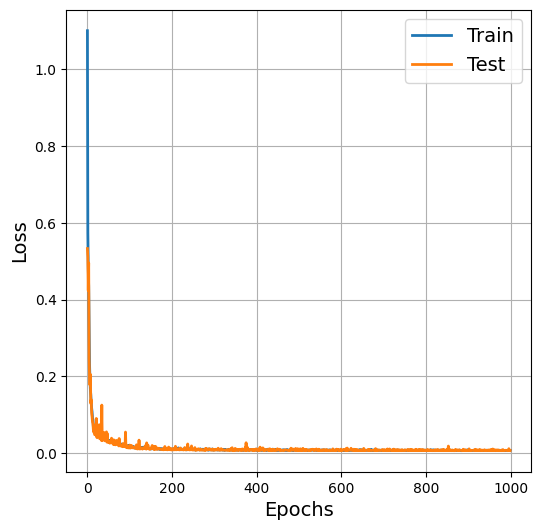

In [14]:
# ==============================================
# 6. Plot Training and Test Loss
# ==============================================
train_losses = np.array(model.train_loss_log)[:, 0]
test_losses = np.array(model.test_loss_log)[:, 0]

plot_loss(train_losses, test_losses, savefile='loss_history.png')


In [15]:
# ==============================================
# 7. Load Model and Predict
# ==============================================
model = torch.load('model.pkl', weights_only=False)

Y_test = test_data['Y_train']
Y_test_pred = model.predict(test_data['X_train'], test_data['X_trunk']).numpy()

print(f"test_out shape: {Y_test.shape}, test_pred shape: {Y_test_pred.shape}")

# Relative L2 errors
error = np.linalg.norm(Y_test - Y_test_pred, axis=1) / np.linalg.norm(Y_test, axis=1)
print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(
    num_test, np.mean(error), np.std(error)
))


test_out shape: (1000, 2601), test_pred shape: (1000, 2601)
Num tests:  1000, Mean Loss (rel l2): 2.709e-02, Std Loss (rel l2): 5.608e-03


i_plot =    18, error (rel l2): 2.200e-02
i_plot =   939, error (rel l2): 2.969e-02
i_plot =   532, error (rel l2): 2.112e-02
i_plot =   671, error (rel l2): 3.061e-02


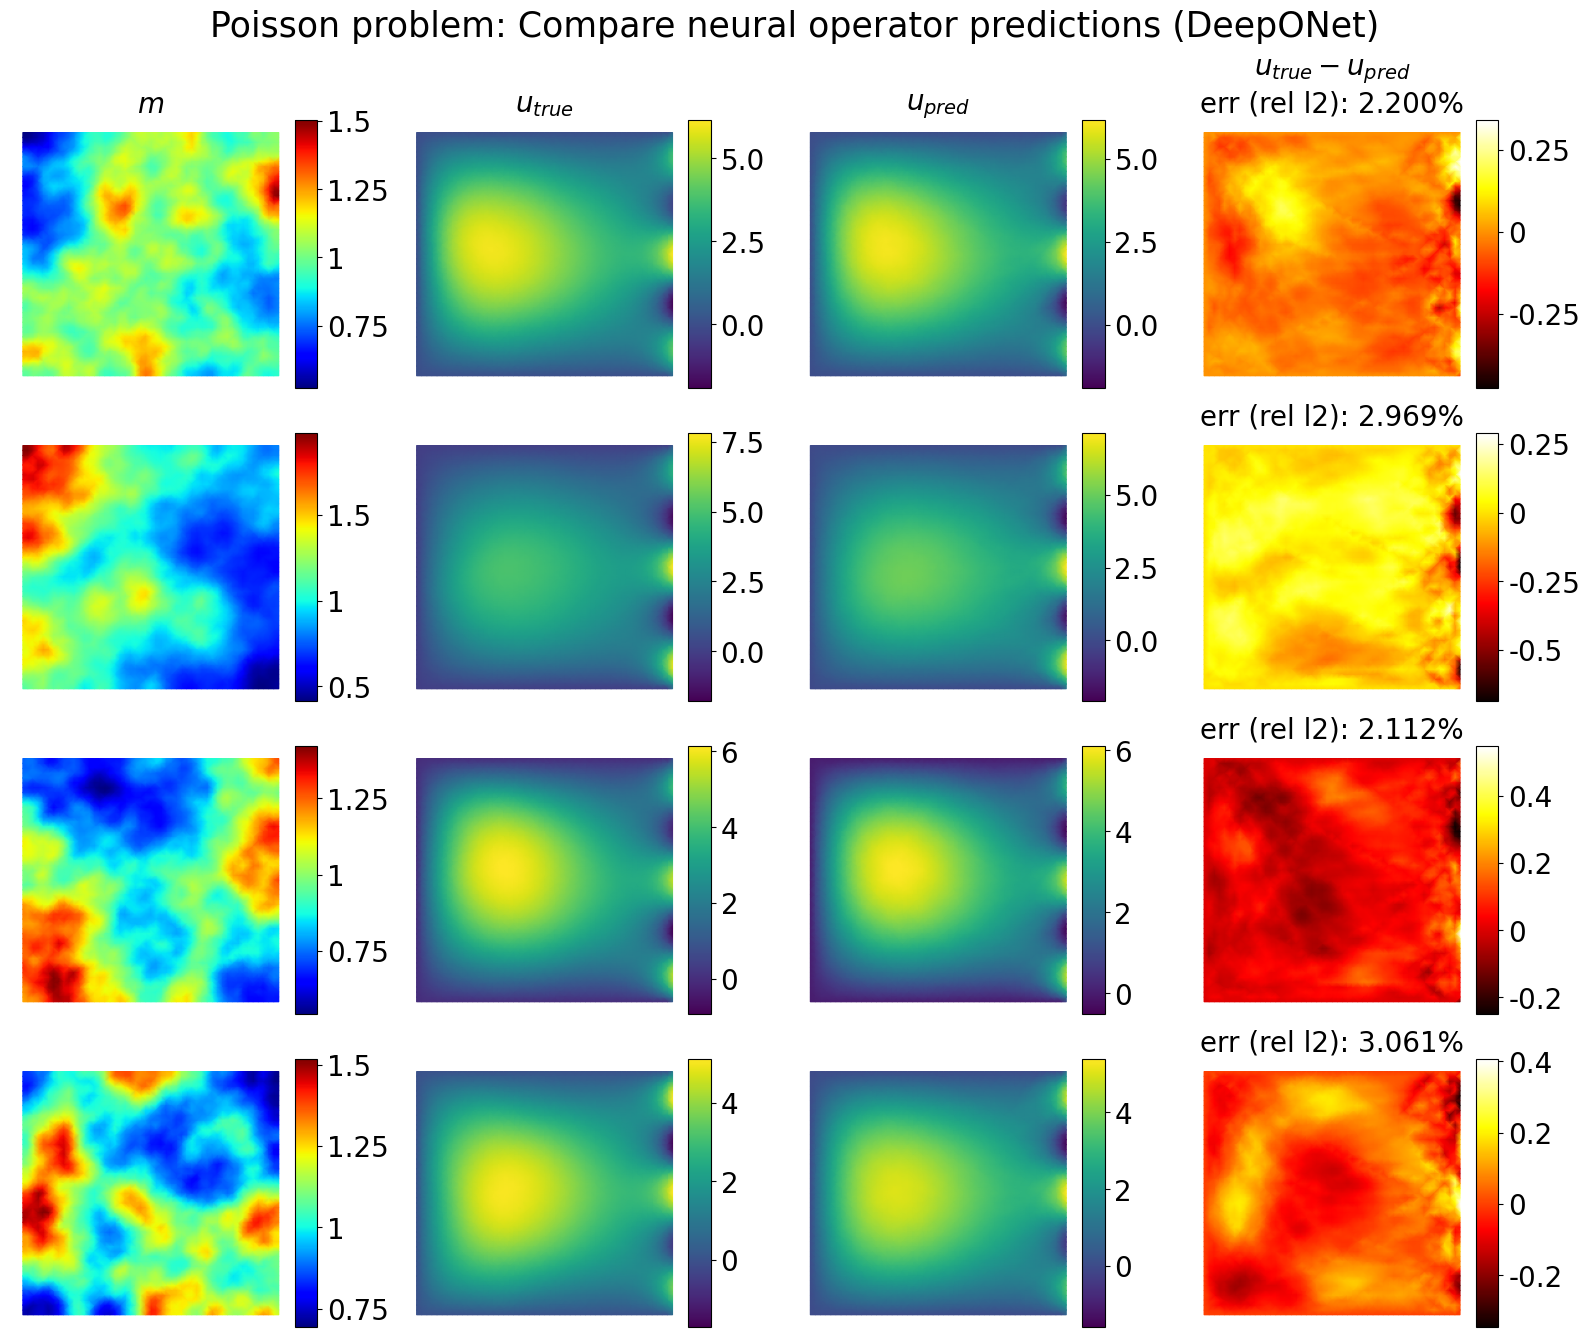

In [17]:
def apply_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids] = bc_value
    return u

rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

u_tags = [r'$m$', r'$u_{true}$', r'$u_{pred}$', r'$u_{true} - u_{pred}$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

nodes = data.X_trunk
decode = True
apply_dirichlet_bc_flag = True

i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    i_plot = i_choices[i]
    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]

    if decode:
        i_pred = data.decoder_Y(i_pred)
        i_truth = data.decoder_Y(i_truth)
        i_m_test = data.decoder_X(i_m_test)

    if apply_dirichlet_bc_flag:
        i_pred = apply_dirichlet_bc(i_pred, 0.0, data.u_mesh_dirichlet_boundary_nodes)
        if np.abs(i_truth[data.u_mesh_dirichlet_boundary_nodes]).max() > 1e-9:
            print(f"Warning: Dirichlet BC not applied to i_truth. Err: {np.abs(i_truth[data.u_mesh_dirichlet_boundary_nodes]).max():.3e}")

    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print(f"i_plot = {i_plot:5d}, error (rel l2): {i_diff_norm:.3e}")

    uvec = [i_m_test, i_truth, i_pred, i_diff]

    for j in range(cols):
        cbar = field_plot(axs[i, j], uvec[j], nodes, cmap=cmaps[j])
        divider = make_axes_locatable(axs[i, j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j in [0, cols-1]:
            kfmt = lambda x, pos: f"{x:g}"
            fig.colorbar(cbar, cax=cax, orientation='vertical', format=kfmt)
        else:
            fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i, j].set_title(u_tags[j], fontsize=fs)

        if j == cols - 1:
            err_str = f"err (rel l2): {i_diff_norm*100:.3f}%"
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i, j].set_title(err_str, fontsize=fs)

        axs[i, j].axis('off')

fig.tight_layout()
fig.suptitle('Poisson problem: Compare neural operator predictions ({})'.format(model.name), fontsize=1.25*fs, y=1.025)
fig.savefig('neural_operator_prediction_comparison.png', bbox_inches='tight')
plt.show()
